In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re

2024-11-12 00:23:36.854712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731345816.872414  410731 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731345816.877429  410731 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 00:23:36.897344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with open("data/cleaned_data.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"The second line (first data point) looks like this:\n\n{csvfile.readline()}")
    print(f"The third line (first data point) looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

Unnamed: 0,statement,status

The second line (first data point) looks like this:

0,oh my gosh,Anxiety

The third line (first data point) looks like this:

1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety



In [3]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
TRAINING_SPLIT = 0.8
BATCH_SIZE = 32
FILENAME = "data/cleaned_data.csv"
STOPWORDS = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [41]:
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

In [49]:
sentences = []
labels = []

with open(FILENAME, 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile) 
    for row in reader_obj: 
        labels.append(row[2])
        sentence = row[1].lower()
        # remove stopwords
        for word in STOPWORDS:
            if word[0] == "'":
                sentence = re.sub(rf"{word}\b", "", sentence)
            else:
                sentence = re.sub(rf"\b{word}\b", "", sentence)

        sentence = re.sub(r'[!"“’#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', ' ', sentence) # remove punctuation mark
        sentence = re.sub(emoj, ' ', sentence) # remove emoji
        sentence = re.sub(r'\d+', ' ', sentence) # remove number
        sentence = re.sub(r' [a-z] ', ' ', sentence) # remove single character
        sentence = re.sub(r'\s+', ' ', sentence) # remove multiple spaces

        sentences.append(sentence)

In [50]:
filtered_sentences = []
filtered_labels = []

for sentence, label in zip(sentences, labels):
    if len(sentence.strip()) > 0:
        filtered_sentences.append(sentence)
        filtered_labels.append(label)

sentences = filtered_sentences
labels = filtered_labels

In [51]:
empty_indices = [i for i, sentence in enumerate(sentences) if len(sentence.strip()) == 0]
print(f"Empty sentences at indices: {empty_indices}")

Empty sentences at indices: []


In [52]:
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

# Shuffle, batch, and prefetch for optimized performance
dataset = dataset.shuffle(buffer_size=len(sentences)) # .batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


In [53]:
train_size = int(len(sentences) * TRAINING_SPLIT)
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

There are 42045 sentence-label pairs for training.

There are 10512 sentence-label pairs for validation.



In [54]:
# clean memory
del sentences
del labels
del dataset
del emoj

In [55]:
def fit_vectorizer(train_sentences, standardize_func):
    '''
    Defines and adapts the text vectorizer

    Args:
        train_sentences (tf.data.Dataset): sentences from the train dataset to fit the TextVectorization layer
        standardize_func (FunctionType): function to remove stopwords and punctuation, and lowercase texts.
    Returns:
        TextVectorization: adapted instance of TextVectorization layer
    '''
    ### START CODE HERE ###
    
    # Instantiate the TextVectorization class, passing in the correct values for the given parameters below
    vectorizer = tf.keras.layers.TextVectorization( 
		standardize=standardize_func,
		max_tokens=VOCAB_SIZE,
		output_sequence_length=MAX_LENGTH
	) 
    
    # Adapt the vectorizer to the training sentences
    vectorizer.adapt(train_sentences)
	
    ### END CODE HERE ###
    
    return vectorizer

In [56]:
# Create the vectorizer
text_only_dataset = train_dataset.map(lambda text, label: text)

# adapt
vectorizer = fit_vectorizer(text_only_dataset, None)

# # skip adapt
# # Load the vocabulary from the file
# with open("vocabulary.txt", "r") as f:
#     vocab = [line.strip() for line in f]

# # Reinitialize the vectorizer and set the vocabulary directly
# vectorizer = tf.keras.layers.TextVectorization(max_tokens=10000, output_mode="int")
# vectorizer.set_vocabulary(vocab)

vocab_size = vectorizer.vocabulary_size()
print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 10000 words



2024-11-12 00:54:56.316058: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [57]:
# Extract the vocabulary
vocab = vectorizer.get_vocabulary()

# Save the vocabulary to a file
with open("vocabulary.txt", "w") as f:
    for word in vocab:
        f.write(word + "\n")

In [58]:
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels) #concatenate the two datasets.
    
    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)
    
    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)
   
    return label_encoder

In [59]:
# Create the label encoder
train_labels_only = train_dataset.map(lambda text, label: label)
validation_labels_only = validation_dataset.map(lambda text, label: label)

label_encoder = fit_label_encoder(train_labels_only,validation_labels_only)
                                  
print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: [np.str_('Normal'), np.str_('Depression'), np.str_('Suicidal'), np.str_('Anxiety'), np.str_('Bipolar'), np.str_('Stress'), np.str_('Personality disorder')]


In [60]:
def preprocess_dataset(dataset, text_vectorizer, label_encoder):
    """Apply the preprocessing to a dataset

    Args:
        dataset (tf.data.Dataset): dataset to preprocess
        text_vectorizer (tf.keras.layers.TextVectorization ): text vectorizer
        label_encoder (tf.keras.layers.StringLookup): label encoder

    Returns:
        tf.data.Dataset: transformed dataset
    """
    
    ### START CODE HERE ###

    # Convert the Dataset sentences to sequences, and encode the text labels
    dataset = dataset.map(lambda text, label:(text_vectorizer(text), label_encoder(label)))
    dataset = dataset.batch(BATCH_SIZE) # Set a batchsize of 32
    
	### END CODE HERE ###
    
    return dataset

In [61]:
# Preprocess dataset
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, label_encoder)

print(f"Number of batches in the train dataset: {train_proc_dataset.cardinality()}")
print(f"Number of batches in the validation dataset: {validation_proc_dataset.cardinality()}")

Number of batches in the train dataset: 1314
Number of batches in the validation dataset: 329


In [62]:
train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 120)
Shape of the validation batch: (32, 120)


In [63]:
def create_model():
    """
    Creates a text classifier model
    Returns:
      tf.keras Model: the text classifier model
    """
   
    ### START CODE HERE ###
	
    # Define your model
    model = tf.keras.Sequential([ 
        tf.keras.Input(shape=(MAX_LENGTH,)),
        tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    
    # Compile model. Set an appropriate loss, optimizer and metrics
    model.compile(
		loss='sparse_categorical_crossentropy',
		optimizer='adam',
		metrics=['accuracy'] 
	) 

    ### END CODE HERE ###

    return model

In [64]:
# Get the untrained model
model = create_model()

In [65]:
example_batch = train_proc_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 7)


In [66]:
history = model.fit(train_proc_dataset, epochs=30, validation_data=validation_proc_dataset)

Epoch 1/30
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.4605 - loss: 1.4234 - val_accuracy: 0.5760 - val_loss: 1.0559
Epoch 2/30
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.6076 - loss: 1.0100 - val_accuracy: 0.6486 - val_loss: 0.8987
Epoch 3/30
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.6541 - loss: 0.8848 - val_accuracy: 0.6941 - val_loss: 0.8179
Epoch 4/30
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.6929 - loss: 0.8033 - val_accuracy: 0.7219 - val_loss: 0.7561
Epoch 5/30
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7283 - loss: 0.7336 - val_accuracy: 0.7483 - val_loss: 0.6769
Epoch 6/30
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7538 - loss: 0.6635 - val_accuracy: 0.7588 - val_loss: 0.6344
Epoch 7/30
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7737 - loss: 0.6176 - val_accuracy: 0.7832 - val_loss: 0.5829
Epoch 8/30
1314/1314 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7864 -

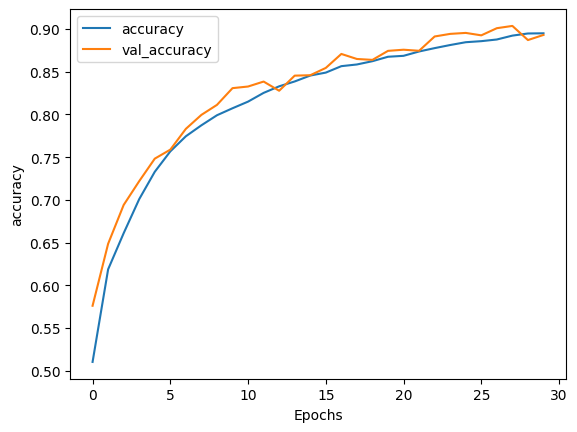

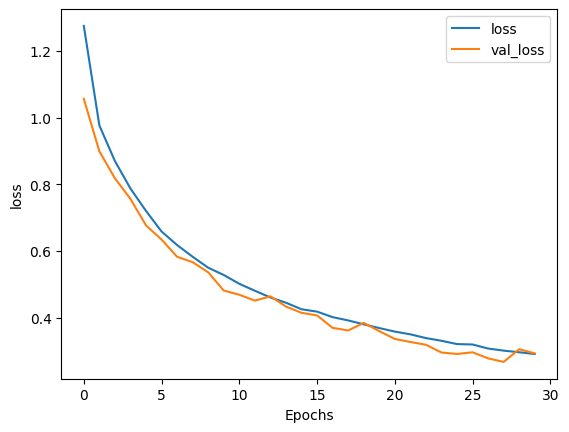

In [67]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [68]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 120, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,175 (1.84 MB)

 Trainable params: 160,391 (626.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,784 (1.22 MB)

In [77]:
rawtext_test = ["I'm really nervous"]
sequence_test = vectorizer(rawtext_test)
print(sequence_test)
predictions = model.predict(sequence_test)

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(predictions)

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {label_encoder.get_vocabulary()[predicted_class_index]}")

tf.Tensor(
[[  1  17 705   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 120), dtype=int64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.31873187 0.06759377 0.03944016 0.5624807  0.00470047 0.00351625
  0.00353676]]
Predicted class: Anxiety
